In [1]:
# Import required modules
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt

In [2]:
# Read the data and use linear interpolation to fill the missing values
df = pd.read_csv("caiso_system_demand.csv", parse_dates=["time"]).set_index("time")
df.system_demand = df.system_demand.interpolate(limit_area="inside")

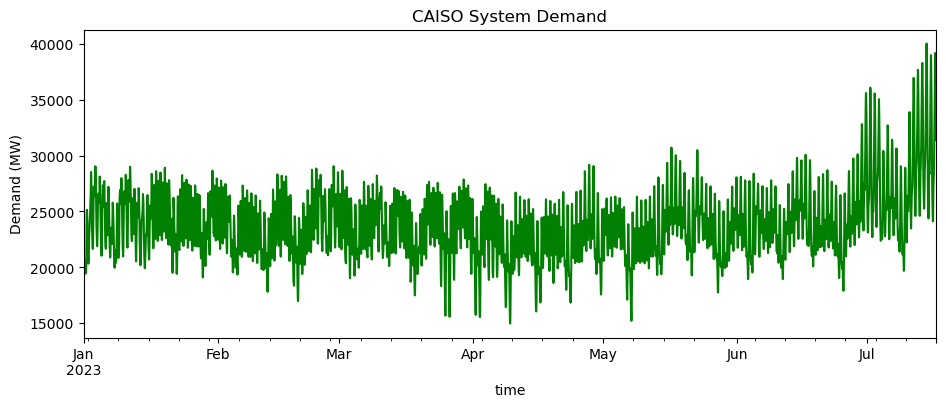

In [3]:
# Plot the data
fig, ax = plt.subplots(figsize=(11, 4))
df.system_demand.plot(ax=ax, color="g")
ax.set_title("CAISO System Demand")
ax.set_ylabel("Demand (MW)")
plt.show()

In [4]:
# Make TensorFlow reproducible by setting random seeds
tf.keras.utils.set_random_seed(43)  # sets seeds for base-python, numpy, and tf
tf.config.experimental.enable_op_determinism()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["system_demand"]])

# Prepare the data for CNN
sequence_length = 24
X, y = [], []

# Create input sequences and corresponding target values
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length, 0])  # Extract the 1D array from the 2D array
    y.append(scaled_data[i+sequence_length, 0])   # Extract the target value

X = np.array(X)
y = np.array(y)

# Reshape X to have 3 dimensions (samples, sequence length, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation="relu", input_shape=(X.shape[1], X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_absolute_error")

# Train the model
model.fit(X, y, epochs=30, batch_size=24)

# Generate forecasts for the next day (72 hours, considering each hour)
last_sequence = scaled_data[-sequence_length:]
forecast = []

# Predict the next 72 hours
for _ in range(72):
    last_sequence = last_sequence.reshape(1, sequence_length, 1)
    next_prediction = model.predict(last_sequence)[0][0]
    forecast.append(next_prediction)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_prediction]]], axis=1)
    
# Inverse scale the forecast
forecast = pd.DataFrame(scaler.inverse_transform(np.array(forecast).reshape(-1, 1)), columns=["forecast"])
forecast["time"] = pd.date_range(start=df.index.max() + pd.Timedelta(hours=1), periods=72, freq="H")
forecast = forecast.set_index("time")

Epoch 1/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0388
Epoch 2/30
196/196 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 3/30
196/196 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 4/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0178
Epoch 5/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0180
Epoch 6/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0163
Epoch 7/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0166
Epoch 8/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0156
Epoch 9/30
196/196 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 10/30
196/196 [==============================] - 1s 3ms/step - loss: 0.0155
Epoch 11/30
196/196 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 12/30
196/196 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 13/30
196/196 [====

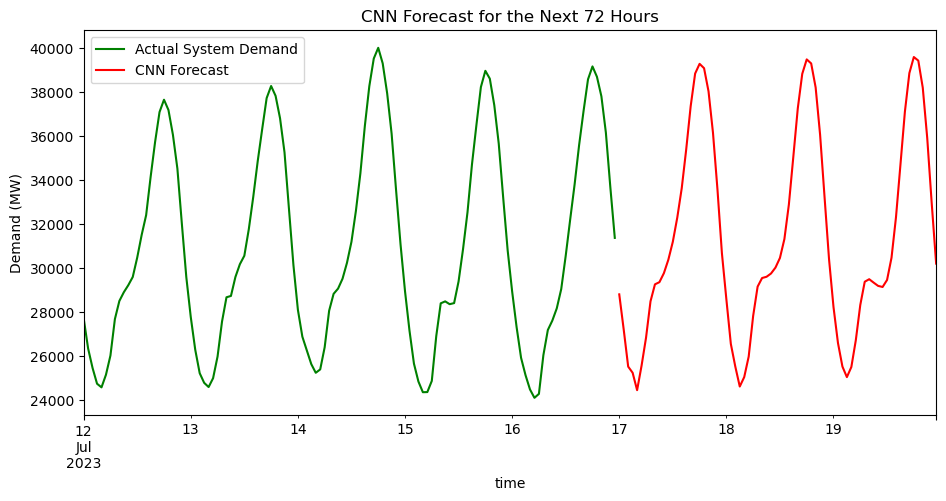

In [5]:
# Plot the actual and forecast together
fig, ax = plt.subplots(figsize=(11, 5))
df.system_demand.tail(120).plot(ax=ax, label="Actual System Demand", color="g")
forecast.forecast.plot(ax=ax, label="CNN Forecast", color="r")
ax.set_title("CNN Forecast for the Next 72 Hours")
ax.set_ylabel("Demand (MW)")
ax.legend()
plt.show()